# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
## YOUR CODE HERE ##
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create training set and define training dataloader
## YOUR CODE HERE ##
train_set = torchvision.datasets.CIFAR10('CIFAR10_data/', download=True, train=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

# Create test set and define test dataloader
## YOUR CODE HERE ##
test_set = torchvision.datasets.CIFAR10('CIFAR10_data/', download=True, train=False, transform=transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=False)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
        
        image = images[i].numpy()
        std = [0.5, 0.5, 0.5]
        mean = [0.5, 0.5, 0.5]
        for i in range(3):
            image[i] = std[i] * image[i] + mean[i]
        plt.imshow(np.transpose(image, (1, 2, 0)))
        plt.show()

In [4]:
# Explore data
## YOUR CODE HERE ##
print('Number of images in the training set:', len(train_set))
print('Number of images in the test set:', len(test_set))

Number of images in the training set: 50000
Number of images in the test set: 10000


truck


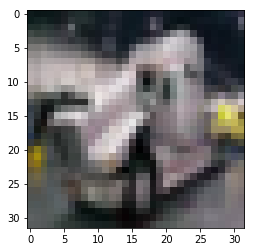

truck


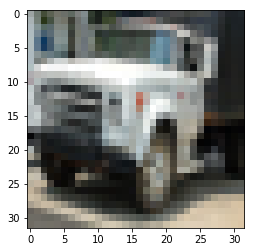

truck


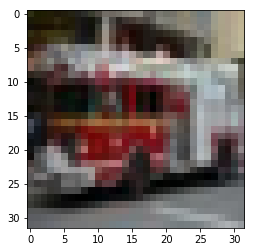

car


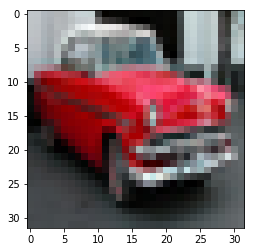

cat


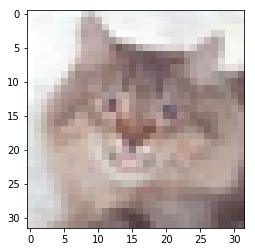

In [5]:
show5(train_loader)

cat


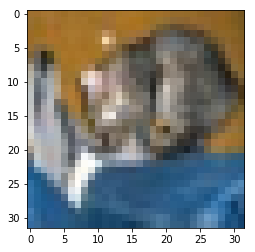

ship


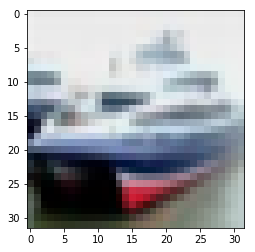

ship


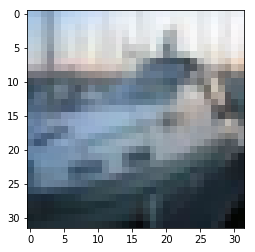

plane


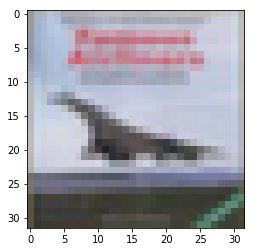

frog


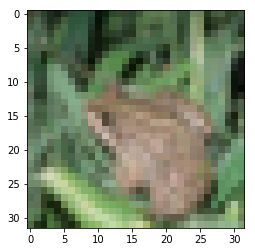

In [6]:
show5(test_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [7]:
## YOUR CODE HERE ##
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 128, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 8 * 8 * 128)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [8]:
## YOUR CODE HERE ##
# Instantiate the model
model = model()

# Specify the loss function. CrossEntropyLoss is widely used for multi-class classification.
criterion = nn.CrossEntropyLoss()

# Specify the optimizer. Adam is commonly used due to its adaptive learning rate properties.
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Starting learning rate of 0.001 is common for Adam.

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
## YOUR CODE HERE ##
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_losses = []

def train(epoch):
    model.train()
    running_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if batch_idx % 250 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    train_losses.append(running_loss/len(train_loader))

for epoch in range(1, 11):
    train(epoch)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.308866
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.509485
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.132828
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.044848
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.784121
Train Epoch: 2 [16000/50000 (32%)]	Loss: 0.830725
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.788621
Train Epoch: 2 [48000/50000 (96%)]	Loss: 0.784620
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.789773
Train Epoch: 3 [16000/50000 (32%)]	Loss: 0.765186
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.009999
Train Epoch: 3 [48000/50000 (96%)]	Loss: 0.522730
Train Epoch: 4 [0/50000 (0%)]	Loss: 0.741024
Train Epoch: 4 [16000/50000 (32%)]	Loss: 0.609299
Train Epoch: 4 [32000/50000 (64%)]	Loss: 0.491111
Train Epoch: 4 [48000/50000 (96%)]	Loss: 0.461930
Train Epoch: 5 [0/50000 (0%)]	Loss: 0.587626
Train Epoch: 5 [16000/50000 (32%)]	Loss: 0.290411
Train Epoch: 5 [32000/50000 (64%)]	Loss: 0.571307
Train Epoch: 5 [48000/50000 (96%)]	Loss: 0.483190
Train Epoch: 6 [0/50000 (

Plot the training loss (and validation loss/accuracy, if recorded).

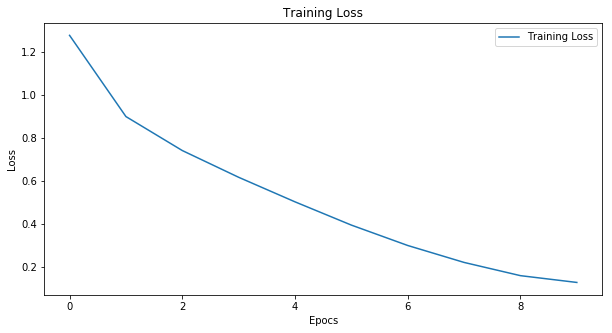

In [10]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epocs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [11]:
## YOUR CODE HERE ##
def test():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' %
          (100 * correct / total))

test()

Accuracy of the network on the 10000 test images: 71 %


## Saving your model
Using `torch.save`, save your model for future loading.

In [12]:
## YOUR CODE HERE ##
model_path = 'model.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Model saved to model.pth


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?



**Double click this cell to modify it**



## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).